In this project I will be building a model for Natural Language Processing with Disaster Tweets. Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). I will be building a GRU RNN model to process the text in tweets for this project.

But, it’s not always clear whether a person’s words are actually announcing a disaster.

The data is downloaded off of kaggle found here: https://www.kaggle.com/competitions/nlp-getting-started/overview

The purpose of this project is to help interested parties quickly identify tweets that are referring to disasters occuring so there can be faster response to the disaster. Another purpose of the project is to help me further my knowledge on building machine learning models. I will also be submitting the results in the ongoing kaggle competition as a third objective.

The dataset has 10,000 tweets stored as a CSV files. It is split between train and test files. The training dataset has a column `target` which is 1 if the tweet was actually referring to a disaster and 0 if the tweet was not referring to a disaster.

The columns for the dataset and the types:
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

EDA

We start with some basic exploration of the data. Viewing some rows from both the test.csv and train.csv files. Note that test.csv file does not have a target column. This means we will need to need to split our training data to create a validation dataset as well.

Another thing to note is that the columns we will be running our analysis on `text` and `target`has values for all of datapoints.

Next we draw a basic plot of counts of how many of the data points have target 0 and 1. Based on the graph it seems that the data is reasonably balanced.

Finally, we draw a wordcloud to get a sense of the most frequent words in the dataset.

This dataset seems clean already and already and nothing needs to be done for the purposes of building our model.

In [19]:
train_data = pd.read_csv("nlp-getting-started/train.csv")
test_data = pd.read_csv("nlp-getting-started/test.csv")

print(train_data.head())
print(test_data.head())
print(train_data.info())
print(test_data.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
<class 'pandas.core.f

<Axes: xlabel='target', ylabel='count'>

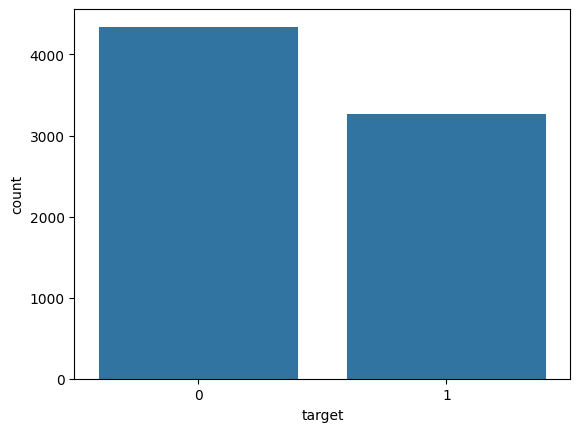

In [9]:
sns.countplot(data=train_data, x = "target")

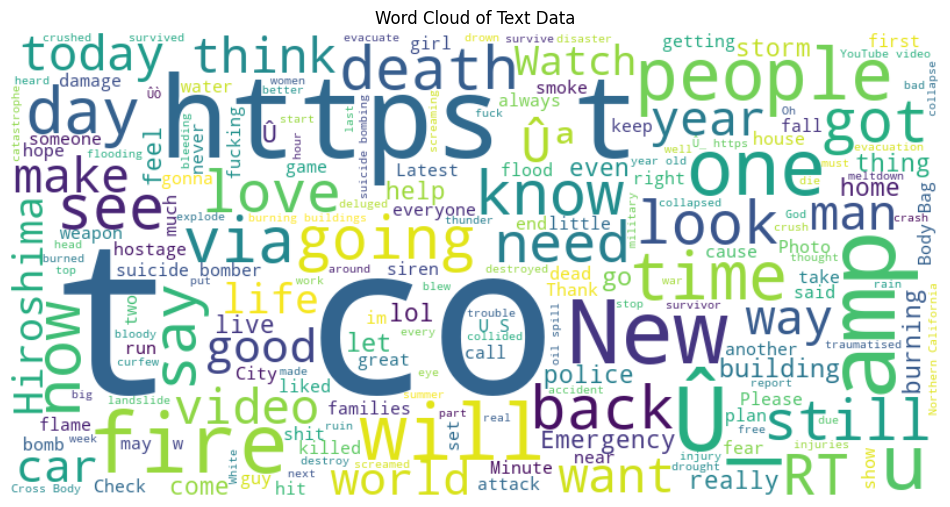

In [18]:
texts = ' '.join(list(train_data['text']) + list(test_data['text']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texts)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

Data Preprocessing and Plan of Analysis

I will be splitting the training dataset into a train and a validation dataset since the test dataset does not have a target column to check our results against. I will be using a split of 0.3.

To preprocess the data for natural language processing I will be doing 3 things:
1. Tokenizing the text data
2. Sequencing the tokens
3. Padding the tokens

Tokenizing the text just splits the text data into individual words and assigns them to a numerical index. Sequencing just replaces the original text with the numeric sequence created from tokenzining. Finally padding ensures that each sequence is of the same size so that the model can efficiently analyze it. 

I also use this opportunity to grab the number of unique words that appear which is 17763. This is used in the Embedding layer of the model later. 

The plan for analyzing the data will be to use a GRU RNN model which is good for natural language processing. We will then be using the following indicators to evaluate the performance of the model:
Accuracy
Precision
Recall
F1-score
ROC-AUC
Confusion Matrix

In [22]:
# split the training data into features (X) and target (y)
X = train_data["text"].values
y = train_data["target"].values

# test dataset
X_test = test_data["text"].values

# split the training data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=42)

# count the number of unique words
unique_count = len(np.unique(X))
unique_test_count = len(np.unique(X_test))

print("\nTraining Data Shape:", X_train.shape)
print("Validation Data Shape:", X_validation.shape)


Training Data Shape: (5329,)
Validation Data Shape: (2284,)


In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Convert the text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_validation)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Define the maximum sequence length
max_sequence_length = 100

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Print the shapes of the padded sequences
print("Training Data Shape (padded):", X_train_pad.shape)
print("Validation Data Shape (padded):", X_val_pad.shape)
print("Test Data Shape (padded):", X_test_pad.shape)

# the number of unique words found with tokenizer

# Initialize the tokenizer

Training Data Shape (padded): (5329, 100)
Validation Data Shape (padded): (2284, 100)
Test Data Shape (padded): (3263, 100)


The architecture I have decided to use for this model is a GRU RNN model with 4 layers:
1. Embedding Layer
2. GRU layer
3. Dense layer with 64 units, activation=relu
4. Dense layer with 1 unit, activation=sigmoid

RNN is great for this problem because it is a natural language processing problem. The sequential data processing works well since the text occurs in a sequence. RNNs can also handle varialbe length input as with the tweets here. The memory cells in the RNN which helps it remember past inputs is espeically useful since the meaning of the words depends on the context and the sentence its used in. Below is why I chose each layer.

The embedding layer converts integer-encoded words into a vector of fixed size. This vector captures the relationship between words.
The GRU layer is a recurrent neural network layer for processing sequential data. It processes both short term and long term memory data in its GRU cells by using a moving average. 
The Dense layer with 64 units and a relu activation function introduces non-linearity and helps the model learn complex patterns.
The final Dense layer with 1 unit and a sigmoid activation function ouputs a probability between 0 and 1 for whether or not the tweet is a natural disaster.

I started this project with onyl Dense (sigmoid) layer but found that it did a poor job of predicting the results when compared against the validation test set. I then added the Dense (relu) layer to add non-linearity which helped the model. 

Here are the results of my experiments with tuning hyperparameters with my final architecture

Results with the following hyperparameters:

1 -----------------------------------

embedding_dim = 100
gru_units=128
gru_dropout=0.2
gru_recurrent_dropout=0.2
batch_size=64
epochs=5

Accuracy: 0.6344133099824869
Precision: 0.5496588324488249
Recall: 0.7505175983436853
F1-score: 0.6345733041575492
ROC-AUC: 0.6499173727682007
Confusion Matrix:
[[724 594]
 [241 725]]

2 -----------------------------------
increasing embedding_dim to 150. dropping gru_dropout to 0.1

embedding_dim = 150
gru_units=128
gru_dropout=0.1
gru_recurrent_dropout=0.2
batch_size=64
epochs=5

Accuracy: 0.7338003502626971
Precision: 0.704337899543379
Recall: 0.6387163561076604
F1-score: 0.6699239956568946
ROC-AUC: 0.7211032463391109
Confusion Matrix:
[[1059  259]
 [ 349  617]]

3 -----------------------------------
increasing gru_unit to 256

embedding_dim = 150
gru_units=256
gru_dropout=0.1
gru_recurrent_dropout=0.2
batch_size=64
epochs=5

Accuracy: 0.7114711033274956
Precision: 0.6945500633713562
Recall: 0.567287784679089
F1-score: 0.6245014245014245
ROC-AUC: 0.6922174886976629
Confusion Matrix:
[[1077  241]
 [ 418  548]]

4 -----------------------------------
decrease gru_unit to 128. increase embedding_dim to 200

embedding_dim = 200
gru_units=128
gru_dropout=0.1
gru_recurrent_dropout=0.2
batch_size=64
epochs=5

Accuracy: 0.7075306479859895
Precision: 0.6307017543859649
Recall: 0.7443064182194618
F1-score: 0.6828110161443495
ROC-AUC: 0.7124415247394729
Confusion Matrix:
[[897 421]
 [247 719]]

5 -----------------------------------
decrease embedding_dim to 175

embedding_dim = 175
gru_units=128
gru_dropout=0.1
gru_recurrent_dropout=0.2
batch_size=64
epochs=5

Accuracy: 0.7136602451838879
Precision: 0.6954887218045113
Recall: 0.5745341614906833
F1-score: 0.6292517006802721
ROC-AUC: 0.6950819517620336
Confusion Matrix:
[[1075  243]
 [ 411  555]]

6 -----------------------------------
decrease embedding_dim to 125

embedding_dim = 125
gru_units=128
gru_dropout=0.1
gru_recurrent_dropout=0.2
batch_size=64
epochs=5

Accuracy: 0.6795096322241682
Precision: 0.5928571428571429
Recall: 0.7732919254658385
F1-score: 0.6711590296495957
ROC-AUC: 0.6920329126570467
Confusion Matrix:
[[805 513]
 [219 747]]

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# the number of unique tokens found with tokenizer
input_dim = len(tokenizer.word_index) + 1

# adjustable hyperparameters
# dimensionality of embedding space words are mapped. higher dimension captures 
# finer semantics of relationship between words
embedding_dim = 150
# number of cells in GRU. higher allows model to capture more complex patterns in data
gru_units=128
# regularization technique used to prevent overfitting by randomly setting a fraction of 
# input units to zero during training. higher makes model more generalizable but hinders convergence
gru_dropout=0.1
# randomly masks a fraction of the recurrent connections during training. similar to grup_dropout
gru_recurrent_dropout=0.2

# Define the model
model = Sequential()

# Add an Embedding layer
# this layer converts integer-encoded words into dense vectors
model.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_sequence_length))

# Add a GRU layer
# extracts relevant features from text
model.add(GRU(units=gru_units, dropout=gru_dropout, recurrent_dropout=gru_recurrent_dropout))

# Add a Dense layer with ReLU activation
# adds non-linearity into the network
model.add(Dense(units=64, activation='relu'))

# Add a Dense output layer with sigmoid activation for binary classification
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [86]:
# adjustable hyperparameters
batch_size=64
epochs=5

history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_pad, y_validation))


Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.6000 - loss: 0.6496 - val_accuracy: 0.7588 - val_loss: 0.5398
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.8730 - loss: 2.9412 - val_accuracy: 0.7504 - val_loss: 0.5268
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9493 - loss: 0.1486 - val_accuracy: 0.7224 - val_loss: 0.6155
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9825 - loss: 0.0642 - val_accuracy: 0.7172 - val_loss: 0.7018
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9917 - loss: 0.0302 - val_accuracy: 0.7172 - val_loss: 0.7650


In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Use your trained model to generate predictions on the validation data
y_pred = model.predict(X_val_pad)
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy proportion of correctly classified samples among all samples
accuracy = accuracy_score(y_validation, y_pred_binary)
print("Accuracy:", accuracy)

# Precision proportion of true positive predictions among all positive predictions made by the model
precision = precision_score(y_validation, y_pred_binary)
print("Precision:", precision)

# Recall the proportion of true positive predictions among all actual positive samples in the dataset
recall = recall_score(y_validation, y_pred_binary)
print("Recall:", recall)

# F1-score harmonic mean of precision and recall
f1 = f1_score(y_validation, y_pred_binary)
print("F1-score:", f1)

# ROC-AUC
# the area under the ROC curve, which plots the true positive rate (TPR) against the 
# false positive rate (FPR) at various threshold settings. It provides an aggregate measure 
# of model performance across all possible classification thresholds. An ROC-AUC value of 0.5
# indicates random guessing, while a value closer to 1 indicates better performance.
if len(np.unique(y_validation)) == 2:
    roc_auc = roc_auc_score(y_validation, y_pred_binary)
    print("ROC-AUC:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_validation, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy: 0.7171628721541156
Precision: 0.6538461538461539
Recall: 0.7039337474120083
F1-score: 0.6779661016949152
ROC-AUC: 0.7153963122492516
Confusion Matrix:
[[958 360]
 [286 680]]


Results and Analysis

The best results I obtained in the end were with the following hyperparameters:

embedding_dim = 150
gru_units=128
gru_dropout=0.1
gru_recurrent_dropout=0.2
batch_size=64
epochs=5

Accuracy: 0.7338003502626971
Precision: 0.704337899543379
Recall: 0.6387163561076604
F1-score: 0.6699239956568946
ROC-AUC: 0.7211032463391109
Confusion Matrix:
[[1059  259]
 [ 349  617]]

Refer to the other markdown block above this for more hyperparameter experiment results. 

I found that increasing the embedding_dim further from 150 actually caused the overall accuracy of the model to go down. When I increased the gru_units hyperparameter which should increase the complexity of the analysis it also reduced the overall accuracy of the model. I believe that increasing the embedding_dim from the intial 100 to 150 was helpful so that the model was able pick out more semantic information of the words and better choose the context in which key words for pointing out natural disasters were actually referring to natural disasters. Increasing gru_units should normally allow for capturing more complex patterns in the data but that reduced my model's accuracy. I believe this is because tweets are relatively short and concise. They are not so overly complex. Usually just a couple of sentences. If the model tries too hard to analyze complex patterns it might actually cause overfitting. Another thing I tested was increasing the epoch size, but as I noted in the graph below, the training loss and validation loss seems to have bottomed out at around 2 epochs so further increasing epochs was not very beneficial.

Troubleshooting the model was basically through iteration. I repeatedly fit the model with different hyperparameters and configurations - not all of which are shown in this final jupyter notebook. For example, I increased the epoch size and had another architecture with fewer layers. By iterating with using the Accuracy score and F1-score as a guideline, I was able to refine the model.

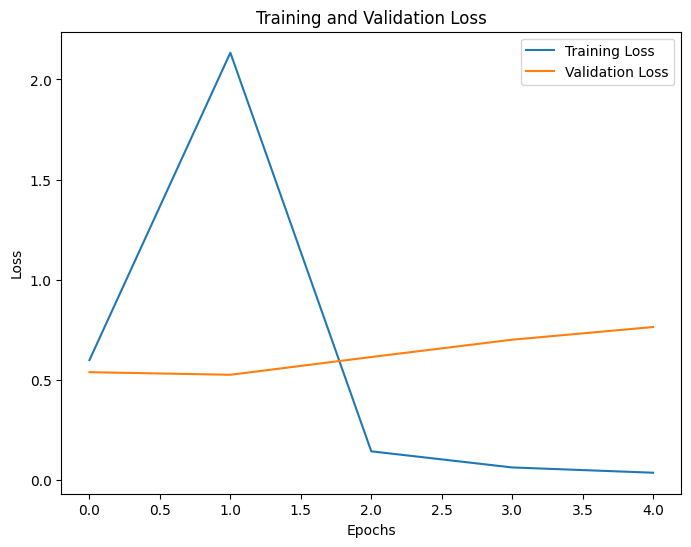

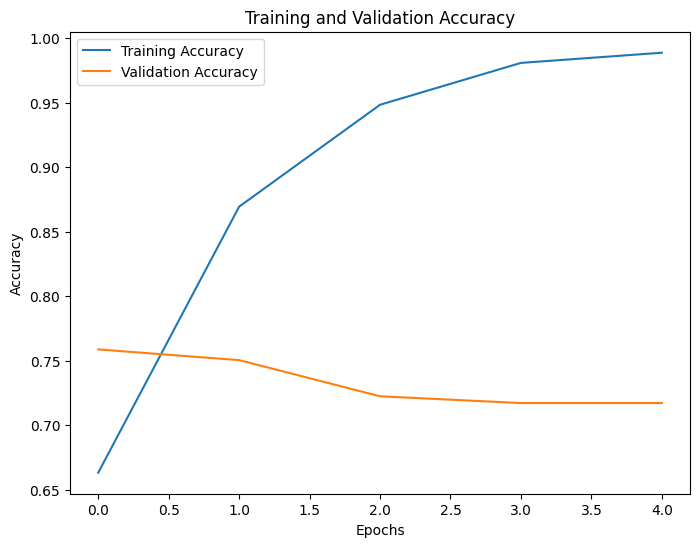

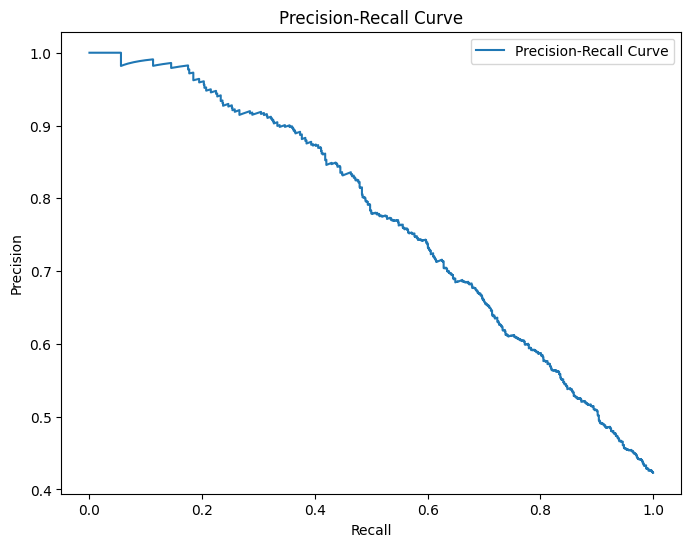

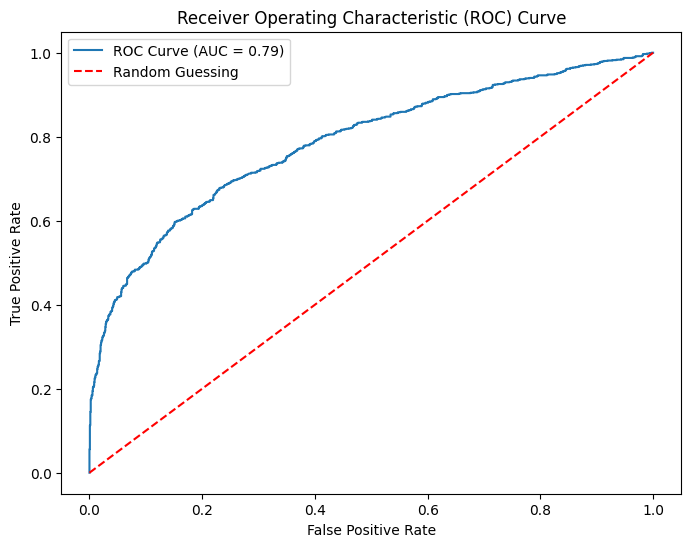

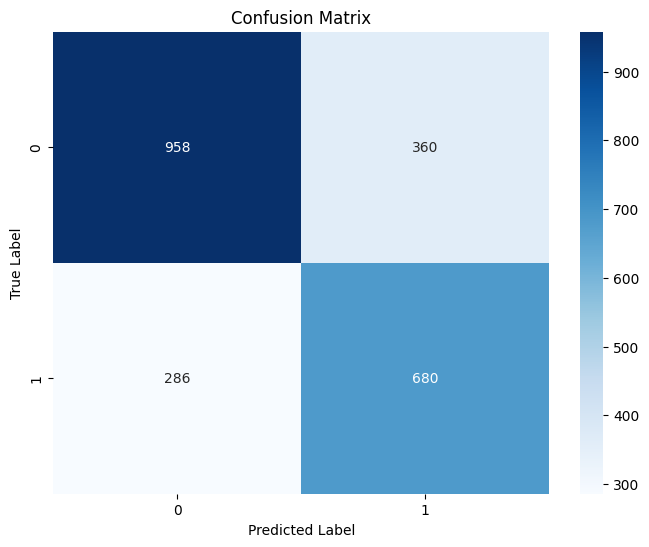

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_validation, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_validation, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_validation, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [89]:
# write model prediction to submission
pred = model.predict(X_test_pad)
sub = pd.read_csv("nlp-getting-started/sample_submission.csv")
sub["target"] = pred
sub["target"] = sub["target"].apply(lambda x : 0 if x<=.5 else 1)
sub.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Conclusion

Using a GRU RNN model, the best results I obtained in the end were with the following hyperparameters:

embedding_dim = 150
gru_units=128
gru_dropout=0.1
gru_recurrent_dropout=0.2
batch_size=64
epochs=5

Accuracy: 0.7338003502626971
Precision: 0.704337899543379
Recall: 0.6387163561076604
F1-score: 0.6699239956568946
ROC-AUC: 0.7211032463391109
Confusion Matrix:
[[1059  259]
 [ 349  617]]

The key learnings and takeaways I got from this analysis was that it helped me better understand sequence data, especially in text data. Since words by themselves often requires the context of the sentence to get the full meaning, it is not useful to simply search for key terms. By adjusting the hyperparameters, I was able to get a better understanding of how each one affected the impact of it on the models performance. For example, I found that increasing the embedding_dim initially helped the accuracy of the model by understanding the word in the context of the sentence, but increasing it too much caused overfitting which reduced the accuracy of the model. 

Another hyperparameter I played around a lot with but did not work well was gru_unit which should have allowed the model to analyze more complex relationships but my testing found that increasing it also reduced the accuracy of my model. This is probably because of the nature of the data in this dataset. Since all the data are tweets which are 280 words max and most tweets do not use the max word count, there is no reason to model for such complex relationships. This analysis also helped me understand the iterative process of machine learning models. How adjusting a parameter a tiny bit could affect the final accuracy of the model.

Some ways that I can improve is to understand the data better through EDA. By performing more EDA and thinking about the data, I probably could have predicted that increasing the gru_unit might not be the best hyperparameter to play around with. To improve the model further, we can probably explore some ensemble techniques or data augmentation techniques to further increase the accuracy.